# Calculate weighted distances between timepoints

In [7]:
import Bio
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

%matplotlib inline

In [2]:
sys.path.insert(0, "../src")

In [3]:
from fit_model import ExponentialGrowthModel

## Load data

In [37]:
tips = pd.read_table("distance-target/standardized_tip_attributes.tsv", parse_dates=["timepoint"])

In [38]:
tips.head()

,strain,branch_length,cTiter,cTiterSub,cTiterSub_x,clade_membership,clock_length,country,country_entropy,dTiter,...,raw_date,rb,region,region_entropy,is_terminal,timepoint,lineage,segment,frequency,naive
0,A/California/7/2004,0.001562,0.904301,-0.969563,1.123122,4ff1302,0.001562,usa,-1.000089e-12,0,...,2004-09-16,5,north_america,-9.998669e-13,True,2004-10-01,h3n2,ha,0.195835,0.0
1,A/Canterbury/201/2004,0.001562,0.904301,-0.969563,1.123122,4ff1302,0.001562,new_zealand,-9.998669e-13,0,...,2004-09-16,5,oceania,-9.998669e-13,True,2004-10-01,h3n2,ha,0.195835,0.0
2,A/Canterbury/23/2004,0.001233,0.904301,-0.969563,1.123122,4ff1302,0.001233,new_zealand,-1.000089e-12,0,...,2004-08-19,5,oceania,-1.000089e-12,True,2004-10-01,h3n2,ha,0.084120,0.0
3,A/HongKong/CUHK33894/2004,0.002156,0.904301,-0.969563,1.123122,4ff1302,0.002156,hong_kong,-1.000089e-12,0,...,2004-05-08,4,china,-1.000089e-12,True,2004-10-01,h3n2,ha,0.000003,0.0
4,A/HongKong/CUHK35435/2004,0.002868,0.904301,-0.969563,1.123122,4ff1302,0.002868,hong_kong,-1.000089e-12,0,...,2004-06-10,4,china,-1.000089e-12,True,2004-10-01,h3n2,ha,0.000250,0.0


In [39]:
tips.columns

Index(['strain', 'branch_length', 'cTiter', 'cTiterSub', 'cTiterSub_x',
       'clade_membership', 'clock_length', 'country', 'country_entropy',
       'dTiter', 'dTiterSub', 'date', 'delta_frequency', 'dms_star', 'ep',
       'ep_x', 'lbi', 'mutation_length', 'ne', 'ne_star', 'numdate',
       'raw_date', 'rb', 'region', 'region_entropy', 'is_terminal',
       'timepoint', 'lineage', 'segment', 'frequency', 'naive'],
      dtype='object')

In [41]:
tips["numdate"].head()

0    2004.711841
1    2004.711841
2    2004.635181
3    2004.353183
4    2004.443532
Name: numdate, dtype: float64

In [43]:
date_by_tip = dict(tips.loc[:, ["strain", "numdate"]].values)

In [13]:
tips["timepoint"].unique()

array(['2004-10-01T00:00:00.000000000', '2005-04-01T00:00:00.000000000',
       '2005-10-01T00:00:00.000000000', '2006-04-01T00:00:00.000000000',
       '2006-10-01T00:00:00.000000000', '2007-04-01T00:00:00.000000000',
       '2007-10-01T00:00:00.000000000', '2008-04-01T00:00:00.000000000',
       '2008-10-01T00:00:00.000000000', '2009-04-01T00:00:00.000000000',
       '2009-10-01T00:00:00.000000000', '2010-04-01T00:00:00.000000000',
       '2010-10-01T00:00:00.000000000', '2011-04-01T00:00:00.000000000',
       '2011-10-01T00:00:00.000000000', '2012-04-01T00:00:00.000000000',
       '2012-10-01T00:00:00.000000000', '2013-04-01T00:00:00.000000000',
       '2013-10-01T00:00:00.000000000', '2014-04-01T00:00:00.000000000',
       '2014-10-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [4]:
distances = pd.read_table("distance-target/target_distances.tsv")

In [5]:
distances.head(20)

,distance,other_sample,sample
0,0,A/Auckland/603/2001,A/Auckland/603/2001
1,3,A/Auckland/611/2002,A/Auckland/603/2001
2,2,A/Auckland/614/2002,A/Auckland/603/2001
3,2,A/Auckland/615/2002,A/Auckland/603/2001
4,19,A/Brisbane/342/2003,A/Auckland/603/2001
5,14,A/Brisbane/5/2002,A/Auckland/603/2001
6,26,A/California/7/2004,A/Auckland/603/2001
7,2,A/Canterbury/16/2002,A/Auckland/603/2001
8,24,A/Canterbury/201/2004,A/Auckland/603/2001
9,23,A/Canterbury/23/2004,A/Auckland/603/2001


In [64]:
distances.shape

(742463, 3)

In [65]:
def calculate_distance_by_time(record):
    if record["sample"] in date_by_tip and record["other_sample"] in date_by_tip:
        delta_time = np.abs(date_by_tip[record["sample"]] - date_by_tip[record["other_sample"]])
        if delta_time > 0:
            return record["distance"] / delta_time
        else:
            return np.nan
    else:
        return np.nan

In [74]:
def calculate_delta_time(record):
    if record["sample"] in date_by_tip and record["other_sample"] in date_by_tip:
        return np.abs(date_by_tip[record["sample"]] - date_by_tip[record["other_sample"]])
    else:
        return np.nan

In [75]:
distances["delta_time"] = distances.apply(calculate_delta_time, axis=1)

In [76]:
distances.head()

,distance,other_sample,sample,distance_by_time,delta_time
0,0,A/Auckland/603/2001,A/Auckland/603/2001,NaN,NaN
1,3,A/Auckland/611/2002,A/Auckland/603/2001,NaN,NaN
2,2,A/Auckland/614/2002,A/Auckland/603/2001,NaN,NaN
3,2,A/Auckland/615/2002,A/Auckland/603/2001,NaN,NaN
4,19,A/Brisbane/342/2003,A/Auckland/603/2001,NaN,NaN


In [78]:
distances["distance_by_time"] = distances["distance"] / distances["delta_time"]

In [84]:
distances_by_time = distances.loc[(~pd.isnull(distances["distance_by_time"])) & (distances["delta_time"] > 0), "distance_by_time"]

In [86]:
distances_by_time.describe()

count    391220.000000
mean         15.790094
std         112.504211
min           0.000000
25%           3.258433
50%           4.712903
75%           8.186268
max        6574.499999
Name: distance_by_time, dtype: float64

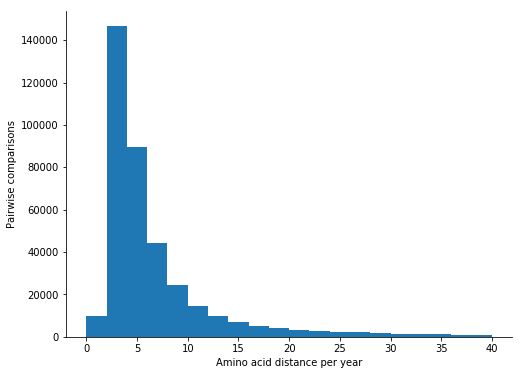

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(distances_by_time[distances_by_time < 40], bins=20)
ax.set_xlabel("Amino acid distance per year")
ax.set_ylabel("Pairwise comparisons")
sns.despine()

In [94]:
distances[(distances["distance_by_time"] > 20) & (distances["distance_by_time"] < 40)]

,distance,other_sample,sample,distance_by_time,delta_time
615,3,A/Canterbury/23/2004,A/California/7/2004,39.133929,0.076660
640,6,A/HongKong/CUHK35435/2004,A/California/7/2004,22.362245,0.268309
662,8,A/Malaysia/28114/2004,A/California/7/2004,25.408696,0.314853
663,5,A/Malaysia/28991/2004,A/California/7/2004,21.485294,0.232717
1068,4,A/Malaysia/29350/2004,A/Canterbury/201/2004,33.976744,0.117728
1117,3,A/California/7/2004,A/Canterbury/23/2004,39.133929,0.076660
1167,5,A/Malaysia/28114/2004,A/Canterbury/23/2004,20.991379,0.238193
4183,6,A/HongKong/CUHK52941/2004,A/HongKong/CUHK33894/2004,21.485294,0.279261
4198,4,A/Malaysia/28991/2004,A/HongKong/CUHK33894/2004,31.760870,0.125941
4199,5,A/Malaysia/29350/2004,A/HongKong/CUHK33894/2004,20.752841,0.240931


In [7]:
distances["distance"].describe()

count    742463.000000
mean         14.108035
std           8.431088
min           0.000000
25%           8.000000
50%          12.000000
75%          19.000000
max          49.000000
Name: distance, dtype: float64

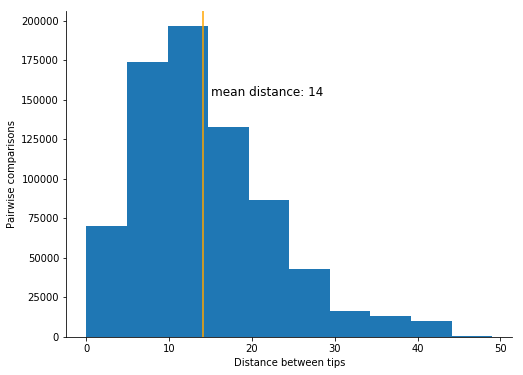

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(distances["distance"])
ax.set_xlabel("Distance between tips")
ax.set_ylabel("Pairwise comparisons")

mean_distance = distances["distance"].mean()
ax.axvline(x=mean_distance, color="orange")
ax.text(
    0.45,
    0.75,
    "mean distance: %.0f" % mean_distance,
    horizontalalignment='center',
    verticalalignment='center',
    transform=ax.transAxes,
    fontsize=12
)
sns.despine()

## Map distances by strain name

In [38]:
distances.head()

,distance,other_sample,sample
0,0,A/Auckland/603/2001,A/Auckland/603/2001
1,3,A/Auckland/611/2002,A/Auckland/603/2001
2,2,A/Auckland/614/2002,A/Auckland/603/2001
3,2,A/Auckland/615/2002,A/Auckland/603/2001
4,19,A/Brisbane/342/2003,A/Auckland/603/2001


In [40]:
distances.values[:10]

array([[0, 'A/Auckland/603/2001', 'A/Auckland/603/2001'],
       [3, 'A/Auckland/611/2002', 'A/Auckland/603/2001'],
       [2, 'A/Auckland/614/2002', 'A/Auckland/603/2001'],
       [2, 'A/Auckland/615/2002', 'A/Auckland/603/2001'],
       [19, 'A/Brisbane/342/2003', 'A/Auckland/603/2001'],
       [14, 'A/Brisbane/5/2002', 'A/Auckland/603/2001'],
       [26, 'A/California/7/2004', 'A/Auckland/603/2001'],
       [2, 'A/Canterbury/16/2002', 'A/Auckland/603/2001'],
       [24, 'A/Canterbury/201/2004', 'A/Auckland/603/2001'],
       [23, 'A/Canterbury/23/2004', 'A/Auckland/603/2001']], dtype=object)

In [41]:
distances_by_strain = {}
for distance, strain_a, strain_b in distances.values:
    if strain_a not in distances_by_strain:
        distances_by_strain[strain_a] = {}
        
    if strain_b not in distances_by_strain:
        distances_by_strain[strain_b] = {}
        
    distances_by_strain[strain_a][strain_b] = distance
    distances_by_strain[strain_b][strain_a] = distance

In [42]:
len(distances_by_strain)

1032

## Calculate observed distance to a future population from each timepoint

In [18]:
timepoints = tips["timepoint"].drop_duplicates()

In [20]:
timepoints

0     2004-10-01
11    2005-04-01
25    2005-10-01
38    2006-04-01
52    2006-10-01
56    2007-04-01
81    2007-10-01
107   2008-04-01
134   2008-10-01
159   2009-04-01
191   2009-10-01
226   2010-04-01
251   2010-10-01
288   2011-04-01
329   2011-10-01
368   2012-04-01
413   2012-10-01
453   2013-04-01
496   2013-10-01
538   2014-04-01
587   2014-10-01
635   2015-04-01
682   2015-10-01
Name: timepoint, dtype: datetime64[ns]

In [21]:
last_timepoint = timepoints.max() - pd.DateOffset(years=1)

In [22]:
last_timepoint

Timestamp('2014-10-01 00:00:00')

In [24]:
valid_timepoints = timepoints[timepoints <= last_timepoint]

In [27]:
timepoints.shape

(23,)

In [26]:
valid_timepoints.shape

(21,)

In [28]:
delta_years = 1

In [49]:
# Calculate weighted distance to the future for each virus at a given timepoint.
weighted_distances = []
for timepoint in valid_timepoints:
    timepoint_tips = tips[tips["timepoint"] == timepoint]
    future_timepoint_tips = tips[tips["timepoint"] == (timepoint + pd.DateOffset(years=1))]
    
    for current_tip, current_tip_frequency in timepoint_tips.loc[:, ["strain", "frequency"]].values:
        weighted_distance_to_present = 0.0
        for other_current_tip, other_current_tip_frequency in timepoint_tips.loc[:, ["strain", "frequency"]].values:
            weighted_distance_to_present += other_current_tip_frequency * distances_by_strain[current_tip][other_current_tip]

        weighted_distance_to_future = 0.0
        for future_tip, future_tip_frequency in future_timepoint_tips.loc[:, ["strain", "frequency"]].values:
            weighted_distance_to_future += future_tip_frequency * distances_by_strain[current_tip][future_tip]

        weighted_distances.append({
            "timepoint": timepoint,
            "strain": current_tip,
            "weighted_distance_to_present": weighted_distance_to_present,
            "weighted_distance_to_future": weighted_distance_to_future
        })

weighted_distances = pd.DataFrame(weighted_distances)

In [52]:
weighted_distances.head()

,strain,timepoint,weighted_distance_to_future,weighted_distance_to_present
0,A/California/7/2004,2004-10-01,6.375681,5.069707
1,A/Canterbury/201/2004,2004-10-01,4.659788,3.853049
2,A/Canterbury/23/2004,2004-10-01,3.659789,3.244720
3,A/HongKong/CUHK33894/2004,2004-10-01,7.374615,6.195280
4,A/HongKong/CUHK35435/2004,2004-10-01,6.374616,5.195287


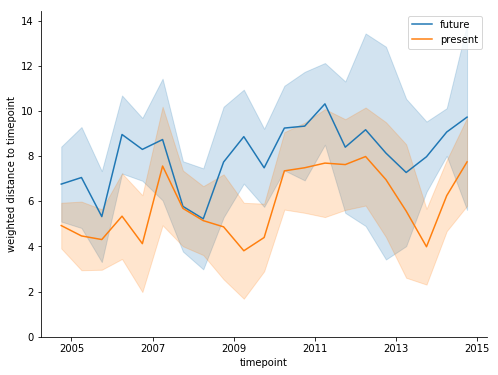

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = sns.lineplot(
    "timepoint",
    "weighted_distance_to_future",
    data=weighted_distances,
    ci="sd",
    label="future",
    ax=ax
)

ax = sns.lineplot(
    "timepoint",
    "weighted_distance_to_present",
    data=weighted_distances,
    ci="sd",
    ax=ax,
    label="present"
)
ax.set_ylabel("weighted distance to timepoint")
ax.set_ylim(bottom=0)
sns.despine()

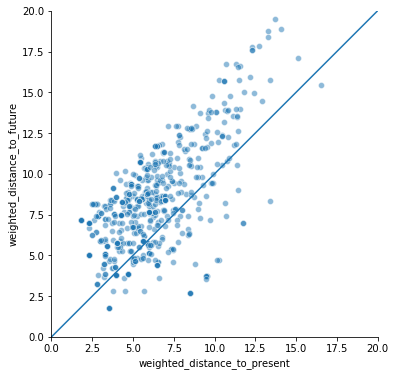

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = sns.scatterplot(
    "weighted_distance_to_present",
    "weighted_distance_to_future",
    data=weighted_distances,
    ax=ax,
    alpha=0.5
)

x = np.linspace(0, 20, 20)
ax.plot(x, x)

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_aspect("equal")
sns.despine()

Samples that fall below the diagonal line are closer to the future than they are to the present. Samples above the line are closer to the present than tha future. We can quantify this pattern with a single value using the log of the ratio of distance to the future over distance to the present.

In [68]:
weighted_distances["log2_distance_effect"] = np.log2(weighted_distances["weighted_distance_to_future"] /
                                                     weighted_distances["weighted_distance_to_present"])

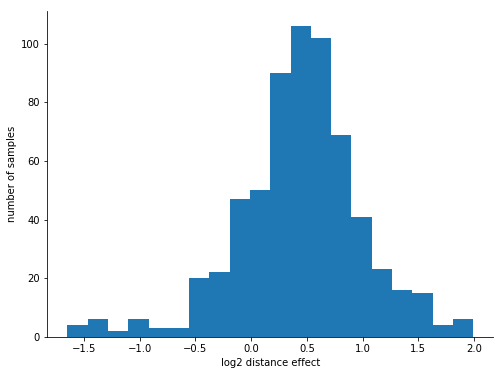

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
output = ax.hist(weighted_distances["log2_distance_effect"], bins=20)
ax.set_xlabel("log2 distance effect")
ax.set_ylabel("number of samples")
sns.despine()

Samples with positive values are closer to the present than the future. Samples with negative values are closer to the future than the present. This view confirms that most samples are closer to the present than the future. A subset of samples through time are closer to the future than the present, though.

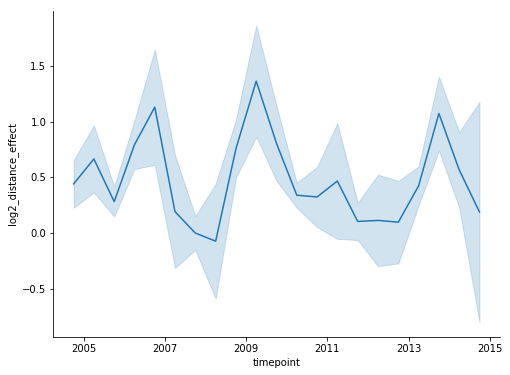

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = sns.lineplot(
    "timepoint",
    "log2_distance_effect",
    data=weighted_distances,
    ci="sd",
    ax=ax
)
sns.despine()

Inspecting the mean +/- std dev of this log2 distance metric by time, we see that on average tips are about the same distance from the present as the future or closer to the present. Peaks could indicate timepoints preceding larger turnover in the global population by the next year.

In [77]:
tips.head()

,strain,branch_length,cTiter,cTiterSub,cTiterSub_x,clade_membership,clock_length,country,country_entropy,dTiter,...,raw_date,rb,region,region_entropy,is_terminal,timepoint,lineage,segment,frequency,naive
0,A/California/7/2004,0.001562,0.904301,-0.969563,1.123122,4ff1302,0.001562,usa,-1.000089e-12,0,...,2004-09-16,5,north_america,-9.998669e-13,True,2004-10-01,h3n2,ha,0.195835,0.0
1,A/Canterbury/201/2004,0.001562,0.904301,-0.969563,1.123122,4ff1302,0.001562,new_zealand,-9.998669e-13,0,...,2004-09-16,5,oceania,-9.998669e-13,True,2004-10-01,h3n2,ha,0.195835,0.0
2,A/Canterbury/23/2004,0.001233,0.904301,-0.969563,1.123122,4ff1302,0.001233,new_zealand,-1.000089e-12,0,...,2004-08-19,5,oceania,-1.000089e-12,True,2004-10-01,h3n2,ha,0.084120,0.0
3,A/HongKong/CUHK33894/2004,0.002156,0.904301,-0.969563,1.123122,4ff1302,0.002156,hong_kong,-1.000089e-12,0,...,2004-05-08,4,china,-1.000089e-12,True,2004-10-01,h3n2,ha,0.000003,0.0
4,A/HongKong/CUHK35435/2004,0.002868,0.904301,-0.969563,1.123122,4ff1302,0.002868,hong_kong,-1.000089e-12,0,...,2004-06-10,4,china,-1.000089e-12,True,2004-10-01,h3n2,ha,0.000250,0.0


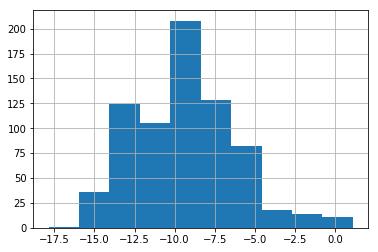

In [87]:
tips["cTiterSub_x"].hist()

In [78]:
weighted_distances.head()

,strain,timepoint,weighted_distance_to_future,weighted_distance_to_present,log2_distance_effect
0,A/California/7/2004,2004-10-01,6.375681,5.069707,0.330677
1,A/Canterbury/201/2004,2004-10-01,4.659788,3.853049,0.274264
2,A/Canterbury/23/2004,2004-10-01,3.659789,3.244720,0.173666
3,A/HongKong/CUHK33894/2004,2004-10-01,7.374615,6.195280,0.251398
4,A/HongKong/CUHK35435/2004,2004-10-01,6.374616,5.195287,0.295135


Samples that have the lowest log2 distance values, shown below, are the most representative individual viruses of the future population at their timepoint. These samples should map near the trunk of the tree. Samples with the highest values are the least representative and should map in unsuccessful side branches.

In [81]:
weighted_distances.sort_values(by="log2_distance_effect").head()

,strain,timepoint,weighted_distance_to_future,weighted_distance_to_present,log2_distance_effect
630,A/Stockholm/18/2014,2014-10-01,2.713941,8.514027,-1.649452
616,A/Nepal/1261B/2014,2014-10-01,2.713941,8.514027,-1.649452
604,A/HongKong/7127/2014,2014-10-01,2.713941,8.514027,-1.649452
602,A/Hawaii/47/2014,2014-10-01,2.713941,8.514027,-1.649452
624,A/Paraguay/86/2014,2014-10-01,3.573039,9.494954,-1.410009


In [82]:
weighted_distances.sort_values(by="log2_distance_effect").tail()

,strain,timepoint,weighted_distance_to_future,weighted_distance_to_present,log2_distance_effect
180,A/Novosibirsk/319/2009,2009-04-01,7.145227,1.795051,1.992955
179,A/NewMexico/3/2009,2009-04-01,7.145227,1.795051,1.992955
176,A/Madagascar/453/2009,2009-04-01,7.145227,1.795051,1.992955
189,A/Victoria/542/2008,2009-04-01,7.145227,1.795051,1.992955
168,A/Kaliningrad/23/2009,2009-04-01,7.145227,1.795051,1.992955


In [90]:
annotated_tips = tips.merge(
    weighted_distances,
    how="inner",
    on=["strain", "timepoint"]
)

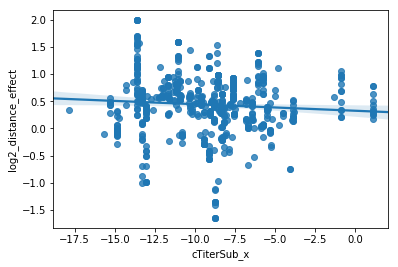

In [91]:
sns.regplot(
    "cTiterSub_x",
    "log2_distance_effect",
    annotated_tips
)

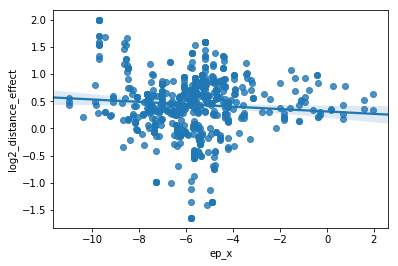

In [92]:
sns.regplot(
    "ep_x",
    "log2_distance_effect",
    annotated_tips
)

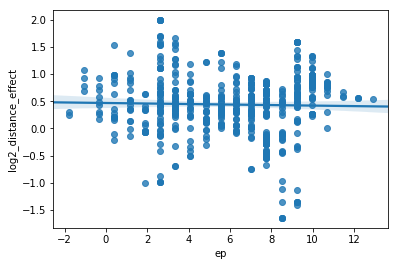

In [93]:
sns.regplot(
    "ep",
    "log2_distance_effect",
    annotated_tips
)

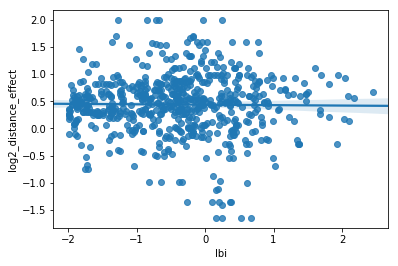

In [100]:
sns.regplot(
    "lbi",
    "log2_distance_effect",
    annotated_tips
)

In [101]:
annotated_tips.head()

,strain,branch_length,cTiter,cTiterSub,cTiterSub_x,clade_membership,clock_length,country,country_entropy,dTiter,...,region_entropy,is_terminal,timepoint,lineage,segment,frequency,naive,weighted_distance_to_future,weighted_distance_to_present,log2_distance_effect
0,A/California/7/2004,0.001562,0.904301,-0.969563,1.123122,4ff1302,0.001562,usa,-1.000089e-12,0,...,-9.998669e-13,True,2004-10-01,h3n2,ha,0.195835,0.0,6.375681,5.069707,0.330677
1,A/Canterbury/201/2004,0.001562,0.904301,-0.969563,1.123122,4ff1302,0.001562,new_zealand,-9.998669e-13,0,...,-9.998669e-13,True,2004-10-01,h3n2,ha,0.195835,0.0,4.659788,3.853049,0.274264
2,A/Canterbury/23/2004,0.001233,0.904301,-0.969563,1.123122,4ff1302,0.001233,new_zealand,-1.000089e-12,0,...,-1.000089e-12,True,2004-10-01,h3n2,ha,0.084120,0.0,3.659789,3.244720,0.173666
3,A/HongKong/CUHK33894/2004,0.002156,0.904301,-0.969563,1.123122,4ff1302,0.002156,hong_kong,-1.000089e-12,0,...,-1.000089e-12,True,2004-10-01,h3n2,ha,0.000003,0.0,7.374615,6.195280,0.251398
4,A/HongKong/CUHK35435/2004,0.002868,0.904301,-0.969563,1.123122,4ff1302,0.002868,hong_kong,-1.000089e-12,0,...,-1.000089e-12,True,2004-10-01,h3n2,ha,0.000250,0.0,6.374616,5.195287,0.295135


In [103]:
annotated_tips.to_csv("distance-target/annotated_tips.tsv", sep="\t", index=False)

## Load amino acid alignments to confirm distances

In [13]:
alignment_paths = [
    "../results/builds/h3n2/1_viruses_per_month/sample_0/2000-10-01--2015-10-01/timepoints/2004-10-01/segments/ha/aa-seq_SigPep.fasta",
    "../results/builds/h3n2/1_viruses_per_month/sample_0/2000-10-01--2015-10-01/timepoints/2004-10-01/segments/ha/aa-seq_HA1.fasta",
    "../results/builds/h3n2/1_viruses_per_month/sample_0/2000-10-01--2015-10-01/timepoints/2004-10-01/segments/ha/aa-seq_HA2.fasta"
]

In [8]:
import Bio.SeqIO

In [16]:
sigpep = Bio.SeqIO.parse(alignment_paths[0], format="fasta")

In [19]:
records_by_name = {}
for alignment_path in alignment_paths:
    for record in Bio.SeqIO.parse(alignment_path, format="fasta"):
        if record.id.startswith("A/"):
            if record.id not in records_by_name:
                records_by_name[record.id] = []
                
            records_by_name[record.id].append(str(record.seq))

In [25]:
sequences_by_name = {}

for record_id, record_sequences in records_by_name.items():
    sequences_by_name[record_id] = "".join(record_sequences)
    assert len(sequences_by_name[record_id]) == 566

In [26]:
distances.head(10)

,distance,other_sample,sample
0,0,A/Auckland/603/2001,A/Auckland/603/2001
1,3,A/Auckland/611/2002,A/Auckland/603/2001
2,2,A/Auckland/614/2002,A/Auckland/603/2001
3,2,A/Auckland/615/2002,A/Auckland/603/2001
4,19,A/Brisbane/342/2003,A/Auckland/603/2001
5,14,A/Brisbane/5/2002,A/Auckland/603/2001
6,26,A/California/7/2004,A/Auckland/603/2001
7,2,A/Canterbury/16/2002,A/Auckland/603/2001
8,24,A/Canterbury/201/2004,A/Auckland/603/2001
9,23,A/Canterbury/23/2004,A/Auckland/603/2001


In [31]:
def print_mismatches(sequence_a, sequence_b):
    distance = 0
    for i in range(len(sequence_a)):
        if sequence_a[i] != sequence_b[i]:
            distance += 1
            print(i, ":", sequence_a[i], ":", sequence_b[i])

    print(distance)

In [32]:
sequence_a = sequences_by_name["A/Auckland/603/2001"]
sequence_b = sequences_by_name["A/Brisbane/5/2002"]
print_mismatches(sequence_a, sequence_b)

65 : R : G
98 : E : K
121 : V : A
146 : A : T
159 : D : N
217 : V : I
237 : W : R
240 : G : D
319 : P : A
362 : M : V
401 : E : G
537 : I : M
544 : I : V
545 : V : A
14


In [33]:
sequence_b = sequences_by_name["A/California/7/2004"]

In [34]:
print_mismatches(sequence_a, sequence_b)

40 : L : I
65 : R : G
90 : H : Q
98 : E : K
121 : V : A
146 : A : T
153 : A : S
159 : D : N
160 : K : N
170 : H : T
171 : Q : H
174 : Y : F
203 : D : N
204 : S : N
211 : A : T
217 : V : I
237 : W : R
240 : G : D
241 : V : I
242 : S : P
319 : P : A
362 : M : V
376 : T : I
401 : E : G
544 : I : V
545 : V : A
26
